In this Task the MNIST Sequence Dataset is used(see https://github.com/edwin-de-jong/mnist-digits-stroke-sequence-data/wiki/MNIST-digits-stroke-sequence-data) to train a sequence prediction model. The dataset consists of sequences generated from the famous MNIST dataset. Based on an input sequences our Model has to predict the remaining sequence. To process the input sequence an encoder model is used. To predict the future sequence a decoder model is used. Additionally a AttentionDecoder is implemented however the code has to be changed to use this Decoder 

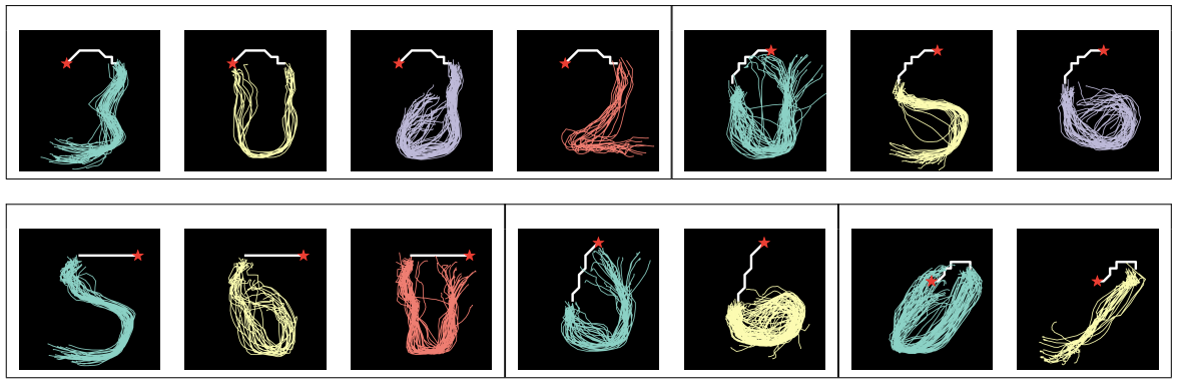

This Tutorial is based on the PyTorch introduction Tutorials (https://pytorch.org/tutorials/)

In [3]:
!pip install -q --upgrade git+https://github.com/FeMa42/prediction_introduction.git

In [4]:
from IPython.display import clear_output

import os
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import random
from predict.download import download_file_from_google_drive
from predict.common import load_data
%matplotlib inline

In [5]:
#####################
# Set parameters
#####################

# Data params
noise_var = 0
num_datapoints = 100
test_size = 0.2
num_train = int((1 - test_size) * num_datapoints)

# Network params
input_size = 2
hidden_layer = 128
output_dim = input_size
num_layers = 2
num_epochs = 500
dtype = torch.float
input_seq = 60
pred_length = 20
batch_size = 32
train_samples = 10
test_samples = 100

device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load data
The loading and preprocessing is based on the implementation of https://github.com/edwin-de-jong/incremental-sequence-learning.

The Data is Downlaoded as numpy files from my personal Google Drive. 
Numpy Data available at https://drive.google.com/file/d/1uaVImXWqdbEhj9euCw8EMKJKsJ7uS7I2/view?usp=sharing

If not possible the Dataset can also be downloaded from https://github.com/edwin-de-jong/mnist-digits-stroke-sequence-data/raw/master/sequences.tar.gz, extracted and processed by load_data().

In [6]:
#####################
# Load data
#####################

extract_file_d = './extracted_data.npy'
if not os.path.isfile(extract_file_d):
    file_id = '1XHWS4PqmnMaR2pID0bPsVtVeohZpKgTF'
    destination = './extracted_data.npy'
    download_file_from_google_drive(file_id, destination)

def prepare_data(data, train=True):
    if train:
        x = data[0:60000, 0:input_seq, :]
        y = data[0:60000, input_seq:input_seq+pred_length, :]
        x = x[0:int(x.shape[0] / batch_size) * batch_size, :]
        y = y[0:int(x.shape[0] / batch_size) * batch_size, :]
        return (x, y)
    else:
        x = data[60000:, 0:input_seq, :]
        y = data[60000:, input_seq:input_seq+pred_length, :]
        x = x[0:int(x.shape[0] / batch_size) * batch_size, :]
        y = y[0:int(x.shape[0] / batch_size) * batch_size, :]
        return (x, y)

data, _ = load_data()
(x_data, y_data) = prepare_data(data, train=True)
(x_data_test, y_data_test) = prepare_data(data, train=False)

output_seq = y_data.shape[1]
print(x_data.shape)
print(y_data.shape)

(60000, 60, 2)
(60000, 20, 2)


torch.Size([32, 60, 2])


c:\users\bdb9fe\appdata\local\continuum\anaconda3\envs\pt36\lib\site-packages\matplotlib\pyplot.py:3358: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


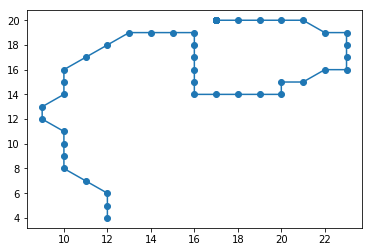

In [7]:
class BatchGenerator(object):
    def __init__(self, data_x, data_y, batch_size=batch_size, output_seq=output_seq, n_action=2):
        self.data_x = data_x  # np.reshape(data_x, (data_x.shape[0], -1))
        self.data_y = data_y  # np.reshape(data_y, (data_y.shape[0], -1))
        self.batch_size = batch_size
        self.output_seq = output_seq
        self.n_action = n_action

    def sample(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        indices = np.random.randint(0, len(self.data_x), batch_size)
        x_batch = torch.tensor(self.data_x[indices, :, :]).to(torch.float)
        y_batch = torch.tensor(self.data_y[indices, :, :]).to(torch.float)
        return x_batch, y_batch


def draw(sequence):
    to_plot = np.array(sequence).squeeze(1)
    df = pd.DataFrame({'x': to_plot[:, 0], 'y': to_plot[:, 1]})
    plt.plot('x', 'y', data=df, linestyle='-', marker='o')

train_data_generator = BatchGenerator(x_data, y_data, batch_size=batch_size)
test_data_generator = BatchGenerator(x_data_test, y_data_test, batch_size=batch_size)

x_batch, y_batch = train_data_generator.sample()
print(x_batch.shape)
draw(torch.cat((x_batch[0, :, :], y_batch[0, :, :]), 0).cpu().unsqueeze(1).numpy().astype(np.float))

## Build Model

### Encoder

An encoder RNN using a GRU layer is used to encode the input sequence. 
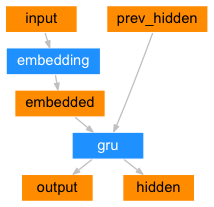

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size=32):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.linear = nn.Linear(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        output = self.linear(input).view(1, batch_size, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

### Decoder
The output sequence is predicted using the DecoderRNN which also uses a GRU layer.  
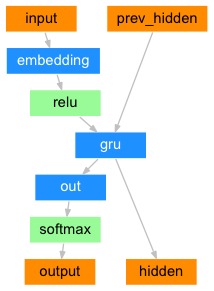

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, batch_size=32):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.linear = nn.Linear(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        output = self.linear(input).view(1, batch_size, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output[0])
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

In [12]:
class DecoderRNN_LSTM(nn.Module):
    def __init__(self, hidden_size, output_size, batch_size=32, num_layers=2):
        super(DecoderRNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers

        self.linear = nn.Linear(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        output = self.linear(input).view(1, batch_size, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output)
        output = self.out(output[0].view(batch_size, -1))
        return output, hidden

    def initHidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_size))

### Attention Decoder
The AttnDecoderRNN uses a Attention layer which enables the Decoder to process all hidden states from the decoder and only paying attention to the neccessary ones. To use this RNN you have to change the training routine (you have to save all hidden states of the decoder and pass it to the attention decoder) 
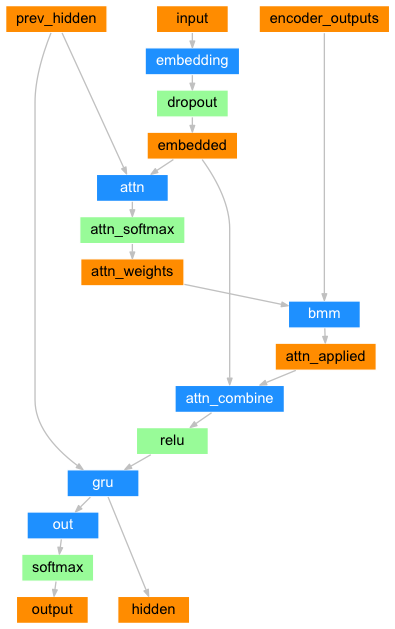

In [13]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=output_seq):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.linear = nn.Linear(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.linear(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = self.out(output[0])
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

hidden_size = 256
encoder = EncoderRNN(input_size, hidden_layer, batch_size=batch_size).to(device)
decoder = DecoderRNN(hidden_layer, output_dim, batch_size=batch_size).to(device)

## Train Function
The training function is similar to the first tutorial. This time we first encode the input sequence and than predict the output sequence using the decoder. 

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability. To avoid the instability it is randomly selected which approach is used to estimate the next input. 

In [14]:
#####################
# Train Function
#####################
loss_fn = torch.nn.MSELoss()
learning_rate = 5e-4
# optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
teacher_forcing_ratio = 0.5


def train(x_tensor, y_tensor):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0

    for e_i in range(x_tensor.size()[1]):
        input_tensor = x_tensor[:, e_i, :]
        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

    decoder_input = input_tensor

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for d_i in range(y_tensor.size()[1]):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            l = loss_fn(decoder_output, y_tensor[:, d_i, :])
            loss += l
            decoder_input = y_tensor[:, d_i, :]
    else:
        for d_i in range(y_tensor.size()[1]):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            l = loss_fn(decoder_output, y_tensor[:, d_i, :])
            loss += l
            decoder_input = decoder_output

    # Backward pass
    loss.backward()

    # Update parameters
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()

def predict(x_tensor, y_tensor, batch_size):
    with torch.no_grad():
        encoder_hidden = torch.zeros(1, batch_size, encoder.hidden_size, device=device)  #  encoder.initHidden()
        loss = 0
        sequence = []
        for e_i in range(x_tensor.size()[1]):
            input_tensor = x_tensor[:, e_i, :]
            encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
            sequence.append(input_tensor.cpu().numpy().astype(np.float))

        decoder_input = input_tensor

        decoder_hidden = encoder_hidden

        for d_i in range(y_tensor.size()[1]):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            l = loss_fn(decoder_output, y_tensor[:, d_i, :])
            loss += l
            decoder_input = decoder_output
            sequence.append(decoder_output.cpu().numpy().astype(np.float))

    return loss.item(), sequence

## Train Model
Since we have a bigger model and more data to process now the training may take a while to converge. 

In [16]:
import time
import math

n_iters = 20000
plot_every = 100
test_size = batch_size

# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_test_losses = []


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    x_batch, y_batch = train_data_generator.sample()
    # category, line, category_tensor, line_tensor = randomTrainingExample()
    loss = train(x_batch, y_batch)
    current_loss += loss

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        print("current_loss: ", current_loss/plot_every)
        all_losses.append(current_loss/plot_every)
        current_loss = 0
        # test_loss
        x_test_batch, y_test_batch = test_data_generator.sample(batch_size=test_size)
        test_loss, _ = predict(x_test_batch, y_test_batch, batch_size=test_size)
        print("current_test_loss: ", test_loss)
        all_test_losses.append(test_loss)

x_test_batch, y_test_batch = test_data_generator.sample(batch_size=5)
for i in range(y_test_batch.size()[0]):
    test_loss, sequence = predict(x_test_batch[i, :, :].unsqueeze(0), y_test_batch[i, :, :].unsqueeze(0), batch_size=1)
    draw(sequence)

plt.figure()
plt.plot(all_losses)
plt.plot(all_test_losses)

current_loss:  647.2706115722656
current_test_loss:  822.8455200195312
current_loss:  615.1352447509765
current_test_loss:  570.9955444335938
current_loss:  487.1162078857422
current_test_loss:  627.296630859375
current_loss:  547.6170257568359
current_test_loss:  699.4378662109375
current_loss:  537.9766021728516
current_test_loss:  636.61962890625
current_loss:  564.3603759765625
current_test_loss:  763.9142456054688
current_loss:  501.1246673583984
current_test_loss:  684.8392333984375
current_loss:  486.7078552246094
current_test_loss:  587.1640625
current_loss:  497.0063201904297
current_test_loss:  725.7161865234375
current_loss:  548.6025665283203
current_test_loss:  633.2852172851562
current_loss:  494.3194915771484
current_test_loss:  460.45928955078125
current_loss:  420.5112243652344
current_test_loss:  718.6376342773438


KeyboardInterrupt: 